In [1]:
import os 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# locate image dir

In [2]:
cwd = os.getcwd()
classes = {'cats', 'dogs'}
writer = tf.python_io.TFRecordWriter('train.tfrecords')

# argument value types func

In [3]:
def _int64_feature(value):
    return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

# convert images to tfrecords

In [4]:
for index, name in enumerate(classes):
    class_path = cwd + '/' + name + '/'
    for img_name in os.listdir(class_path):
        img_path = class_path + img_name    
        img = Image.open(img_path)
        img = img.resize((128, 128))
        # convert images to byte
        img_raw = img.tobytes() 
        example = tf.train.Example(features = tf.train.Features(feature = {
                  "label": _int64_feature(index),
                  "img_raw": _bytes_feature(img_raw), }))
        writer.write(example.SerializeToString())
writer.close()

# read data from TFRecords func

In [5]:
def read_and_decode(filename, batch_size): # read train.tfrecords
    filename_queue = tf.train.string_input_producer([filename])# create a queue

    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)#return file_name and file
    features = tf.parse_single_example(serialized_example,
               features={'label': tf.FixedLenFeature([], tf.int64),
               'img_raw' : tf.FixedLenFeature([], tf.string),})#return image and label

    img = tf.decode_raw(features['img_raw'], tf.uint8)
    img = tf.reshape(img, [128, 128, 3])  #reshape image to 256*256*3
    label = tf.cast(features['label'], tf.int32) #throw label tensor

    img_batch, label_batch = tf.train.shuffle_batch([img, label],
                             batch_size= batch_size,
                             num_threads=64,
                             capacity=2000,
                             min_after_dequeue=1500,)
    return img_batch, tf.reshape(label_batch,[batch_size])

# show TFRecords images

Tensor("shuffle_batch:0", shape=(4, 128, 128, 3), dtype=uint8)
Tensor("Reshape_1:0", shape=(4,), dtype=int32)
label: 1


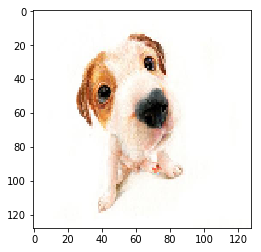

label: 1


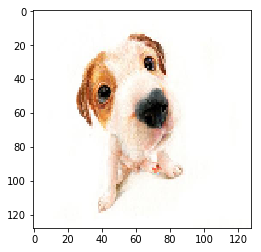

label: 0


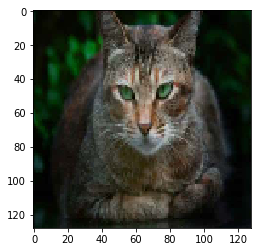

label: 1


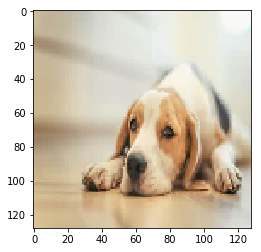

In [6]:
tfrecords_file = 'train.tfrecords'
batch_size = 4
image_batch, label_batch = read_and_decode(tfrecords_file, batch_size)
print(image_batch)
print(label_batch)

with tf.Session()  as sess:
    i = 0
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    try:
        while not coord.should_stop() and i<1:
            # just plot one batch size
            image, label = sess.run([image_batch, label_batch])
            for j in np.arange(4):
                print('label: %d' % label[j])
                plt.imshow(image[j,:,:,:])
                plt.show()
            i+=1
    except tf.errors.OutOfRangeError:
        print('ERROR!')
    finally:
        coord.request_stop()
    coord.join(threads)